<h1><center>SEIS 763 Machine Learning<br>Team 4 Project - Backward Elimination<br>Wess Kilker&emsp;Tianyu Lei&emsp;Jason Xiao &emsp;Jessica Zastoupil</center></h1>

### Data Load, Feature Updates & Data Prep

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use the encoding as latin1 to read this file as there are some special characters in the file
df = pd.read_csv('SeoulBikeData.csv',encoding='latin1')

# Filter out non functioning days
df = df.loc[df['Functioning Day'] == 'Yes']

#Add Weekday Column
df['DayOfWeek'] = pd.to_datetime(df['Date']).apply(lambda x: x.weekday())

# Move rented bike count to end and remove unneeded features: Date and Functioning Day
df = df[['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
         'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday','DayOfWeek', 'Rented Bike Count']]

# Split into X and y
X = df.iloc[:,0:-1].values #All except the last column
y = df.iloc[:,-1].values #Only the last column

# Deal with categorical variables: OneHot Encoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
col_trans = make_column_transformer((OneHotEncoder(), [9,10]), remainder='passthrough')
X = col_trans.fit_transform(X)

# Drop excess column for each encoded feature
X=X[:,[1,2,3,5,6,7,8,9,10,11,12,13,14,15]]

# Normalizing the features
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)


### Backward Elimination

In [ ]:
#Results in X & y, unsplit
#We split after Backward elimination so that we have the same number of features in our X_train and X_test
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from sklearn.metrics import mean_squared_error

def backwardElimination(y, x, factor):
    #find beginning # of features
    numFeatures = len(x[0])
    # start with all predictors
    for i in range(0, numFeatures):
        #fit model using OLS regression
        beOLS = sm.OLS(y, x).fit()
        #get p-value
        maxVar = max(beOLS.pvalues).astype(float)
        #print(i, maxVar)
        #drop most irrelevant factor
        if maxVar > factor:
            for j in range(0, numFeatures - i):
                if (beOLS.pvalues[j].astype(float) == maxVar):
                    print("Deleted " + str(i))
                    x = np.delete(x, j, 1)
        #repeat until all factors are statistically relevant (p<.05)
    print(beOLS.summary())
    return x

#Apply Backward Elimination to X
#previous exploration determined that backward elimination removed the same number of features for factors between .01 and .08
factor = .05
X = backwardElimination(y,X,factor)
print(X.shape)
print(y.shape)

#Split into train and test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Deleted 0
Deleted 1
Deleted 2
Deleted 3
Deleted 4
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.236
Model:                            OLS   Adj. R-squared (uncentered):              0.235
Method:                 Least Squares   F-statistic:                              290.4
Date:                Sat, 05 Dec 2020   Prob (F-statistic):                        0.00
Time:                        01:46:44   Log-Likelihood:                         -69103.
No. Observations:                8465   AIC:                                  1.382e+05
Df Residuals:                    8456   BIC:                                  1.383e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

### Models

#### Linear Regression

In [ ]:
#Linear Regression after Backward Elimination 
lrObj = LinearRegression().fit(X_train, y_train)
y_pred_lr = lrObj.predict(X_test)
#accuracy 
score_LR= lrObj.score(X_test,y_test)
print('Accuracy: ' + str(score_LR))

# mean squared error/Root Mean Square Error
mse_lr=(mean_squared_error(y_test, y_pred_lr))/100
rmse_lr = (np.sqrt(mse_lr))/100 

print("MSE:", mse_lr)
print("RMSE:",rmse_lr)

#K-Fold Cross Validation
print('Cross Validation')
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=lrObj, X=X_train, y=y_train, cv=10)
print('Model Accuracy Mean:',modelAccuracies.mean())
print('Model Accuracy StDev:',modelAccuracies.std())

Accuracy: 0.536589639493575
MSE: 1875.7432811727167
RMSE: 0.4330985201051507
Cross Validation
Model Accuracy Mean: 0.5379803802209681
Model Accuracy StDev: 0.026428553241233384


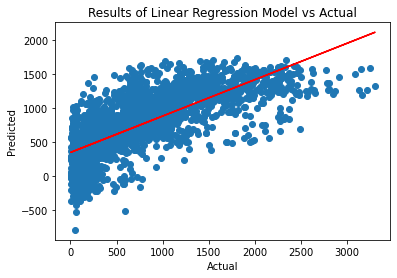

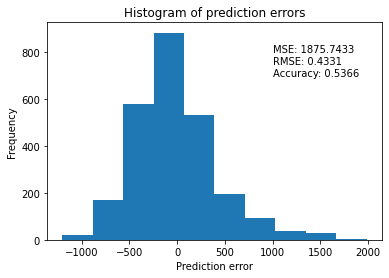

In [ ]:
#Visualizing after Linear Regression
import matplotlib.pyplot as plt

#compare results vs actual
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_lr)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Results of Linear Regression Model vs Actual')
#regression line
y_t, y_p = y_test.reshape(-1,1), y_pred_lr.reshape(-1,1)
ax.plot(y_t, LinearRegression().fit(y_t, y_p).predict(y_t), color='red')
plt.show()


plt.hist(y_test - y_pred_lr)
plt.annotate("MSE: " + str(round(mse_lr,4)) + "\nRMSE: " +str(round(rmse_lr,4)) + "\nAccuracy: " + str(round(score_LR,4)), (1000,700))
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')
plt.show()

#### Polynomial Regression

In [ ]:
#skip this (unless you want to rerun, takes awhile), added best degree assignment to next cell
#find best number of degrees
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
rmses = []
degrees = np.arange(1, X_train.shape[1]-1)
min_rmse, min_deg = 1e10, 0

for deg in degrees:
    # Train features
    poly_features = PolynomialFeatures(degree=deg)
    x_poly_train = poly_features.fit_transform(X_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    X_poly_test = poly_features.fit_transform(X_test)
    poly_predict = poly_reg.predict(X_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

#Results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

d=min_deg

Best degree 3 with RMSE 298.8649678552334


In [ ]:
# Polynomial Regression after Backward Elimination
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

#assign best number of degrees from code above so I dont have to rerun that code every time
d=3

#create our X for polynomial regression
polyFeatureObj = PolynomialFeatures(degree=d)
X_poly = polyFeatureObj.fit_transform(X)
#Split into train and test for Polynomial Regression using X_poly
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size=0.3,random_state=0)

#fit model
polyObj=LinearRegression()
model = polyObj.fit(X_train_poly, y_train_poly)

#Prediction on the Test Set
y_pred_poly = polyObj.predict(X_test_poly)
score_poly = model.score(X_test_poly, y_test_poly)

#accuracy
print('The accuracy after Polynomial (degree='+str(d)+') is: ' + str(score_poly))

# mean squared error/Root Mean Square Error
from sklearn.metrics import mean_squared_error
mse_poly=round((mean_squared_error(y_test_poly, y_pred_poly))/100, 4)
rmse_poly = round((np.sqrt(mse_poly))/100 ,4)

print("MSE:", mse_poly)
print("RMSE:",rmse_poly)

#K-Fold Cross Validation
print('Cross Validation')
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=polyObj, X=X_train_poly, y=y_train_poly, cv=10)
print('Model Accuracy Mean:',modelAccuracies.mean())
print('Model Accuracy StDev:',modelAccuracies.std())

The accuracy after Polynomial (degree=3) is: 0.7793304740663077
MSE: 893.2027
RMSE: 0.2989
Cross Validation
Model Accuracy Mean: 0.7415014203601663
Model Accuracy StDev: 0.051421527079081084


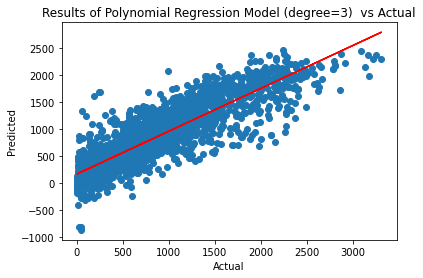

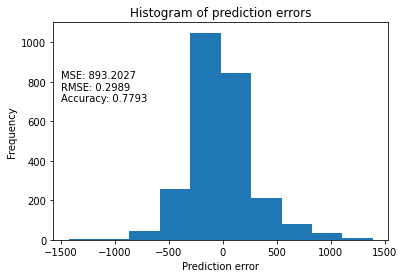

In [ ]:
#Visualizing after Polynomial Regression
import matplotlib.pyplot as plt

#compare results vs actual
fig, ax = plt.subplots()
ax.scatter(y_test_poly, y_pred_poly)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Results of Polynomial Regression Model (degree=3)  vs Actual')
#regression line
y_t, y_p = y_test_poly.reshape(-1,1), y_pred_poly.reshape(-1,1)
ax.plot(y_t, polyObj.fit(y_t, y_p).predict(y_t), color='red')
plt.show()


plt.hist(y_test_poly - y_pred_poly)
plt.annotate("MSE: " + str(round(mse_poly,4)) + "\nRMSE: " +str(round(rmse_poly,4)) + "\nAccuracy: " + str(round(score_poly,4)), (-1500,700))
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')
plt.show()

#### Tree Forest

In [ ]:
#Tree Forest after Backward Elimination
from sklearn.ensemble import RandomForestRegressor

#get default baseline results
tfObj = RandomForestRegressor(random_state=0)
tfObj.fit(X_train,y_train)
y_pred_tf = tfObj.predict(X_test)

score_tf = tfObj.score(X_test,y_test)

#accuracy
print('The default Tree Forest Regression accuracy is: ' + str(score_tf))
# mean squared error/Root Mean Square Error
from sklearn.metrics import mean_squared_error
mse_tf=(mean_squared_error(y_test, y_pred_tf))/100
rmse_tf = (np.sqrt(mse_tf))/100
print("MSE:", mse_tf)
print("RMSE:",rmse_tf)

#K-Fold Cross Validation
print('\nCross Validation:')
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=tfObj, X=X_train, y=y_train, cv=10)
print('Model Accuracy Mean:',modelAccuracies.mean())
print('Model Accuracy StDev:',modelAccuracies.std())

The default Tree Forest Regression accuracy is: 0.8554446502630271
MSE: 585.1158047704887
RMSE: 0.2418916709542701

Cross Validation:
Model Accuracy Mean: 0.8574703634798009
Model Accuracy StDev: 0.013183965970542222



Cross Validation with Random Forest Estimators set to 360


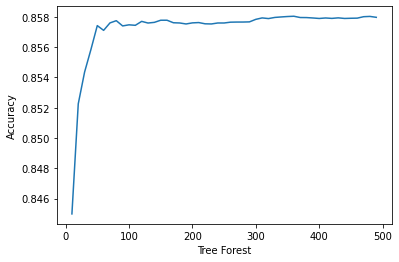

In [ ]:
# Tree Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

X_Results = np.empty((0), int)
Y_Results = np.empty((0), float)
for i in range(10,500,10):
    #Create and Fit a Regressor Object
    
    regObj = RandomForestRegressor(n_estimators=i,random_state= 0)
    regObj.fit(X_train,y_train)
    reg_pred_y = regObj.predict(X_test)   
    modelAccuracies = cross_val_score(estimator=regObj, X=X_train, y=y_train, cv=10)
    
    X_Results = np.append(X_Results, [i], axis = 0)
    Y_Results = np.append(Y_Results, [modelAccuracies.mean()], axis = 0)
     
plt.xlabel('Tree Forest')
plt.ylabel('Accuracy')
plt.plot(X_Results, Y_Results)
maxY = max(Y_Results)
#Keep the best result for use later
y_index = np.where(Y_Results == maxY)
numEst = X_Results[y_index][0]
print('\nCross Validation with Random Forest Estimators set to ' + str(numEst) )


In [ ]:
#Random Forest Regression

#assign best n_estimators from code above so I dont have to rerun that code every time
numEst=360

tfObj = RandomForestRegressor(n_estimators=numEst,random_state= 0)
tfObj.fit(X_train,y_train)
y_pred_tf = tfObj.predict(X_test)
score_tf = tfObj.score(X_test,y_test)

#accuracy
print('The Tree Forest Regression accuracy(n=' + str(numEst)+ ') is: ' + str(score_tf))

# mean squared error/Root Mean Square Error
from sklearn.metrics import mean_squared_error
mse_tf=(mean_squared_error(y_test, y_pred_tf))/100
rmse_tf = (np.sqrt(mse_tf))/100
print("MSE:", mse_tf)
print("RMSE:",rmse_tf)

#K-Fold Cross Validation
print('\nCross Validation:')
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=tfObj, X=X_train, y=y_train, cv=10)
print('Model Accuracy Mean:',modelAccuracies.mean())
print('Model Accuracy StDev:',modelAccuracies.std())

The Tree Forest Regression accuracy(n=360) is: 0.8558731604404124
MSE: 583.3813267470234
RMSE: 0.2415328811460302

Cross Validation:
Model Accuracy Mean: 0.858036494798284
Model Accuracy StDev: 0.013349125107507161


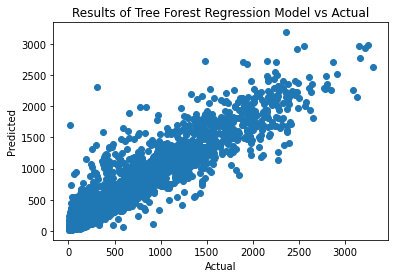

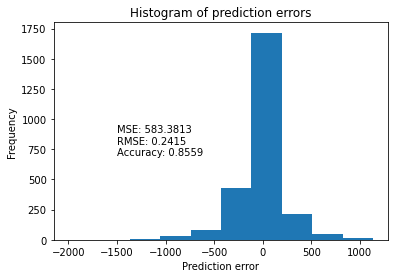

In [ ]:
#Visualizing after Tree Forest Regression
import matplotlib.pyplot as plt

#compare results vs actual
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_tf)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Results of Tree Forest Regression Model vs Actual')
plt.show()


plt.hist(y_test - y_pred_tf)
plt.annotate("MSE: " + str(round(mse_tf,4)) + "\nRMSE: " +str(round(rmse_tf,4)) + "\nAccuracy: " + str(round(score_tf,4)), (-1500,700))
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')
plt.show()

#### KNN Regressor

In [ ]:
#KNN - Regression  after Backward Elimination
from sklearn.neighbors import KNeighborsRegressor

X_Results = np.empty((0), int)
Y_Results = np.empty((0), float)
for i in range(1,20, 1):
    KNeighborsRegressorObj = KNeighborsRegressor(n_neighbors=i, p=2, metric='minkowski')
    KNeighborsRegressorObj.fit(X_train, y_train)
    
    #Making predictions on the Test Set
    y_pred_knn = KNeighborsRegressorObj.predict(X_test)

    X_Results = np.append(X_Results, [i], axis = 0)
    Y_Results = np.append(Y_Results, [1-KNeighborsRegressorObj.score(X_test,y_test)], axis = 0)

minY = min(Y_Results)
y_index = np.where(Y_Results == minY)

#Keep the best result for use later
KNeighborsRegressorObj = KNeighborsRegressor(n_neighbors=X_Results[y_index][0], p=2, metric='minkowski')
KNeighborsRegressorObj.fit(X_train, y_train)

#Making predictions on the Test Set
y_pred_knn = KNeighborsRegressorObj.predict(X_test)

#accuracy 
score_knn = KNeighborsRegressorObj.score(X_test,y_test)
print('The accuracy after kNN is: ' + str(score_knn))

# mean squared error/Root Mean Square Error
mse_knn=round((mean_squared_error(y_test, y_pred_knn))/100, 4)
rmse_knn = round((np.sqrt(mse_knn))/100 ,4)

print("MSE:", mse_knn)
print("RMSE:",rmse_knn)


#K-Fold Cross Validation
print('\nCross Validation with kNN set to ' + str(X_Results[y_index][0]) + ':')
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=KNeighborsRegressorObj, X=X_train, y=y_train, cv=10)
print('Model Accuracy Mean:',modelAccuracies.mean())
print('Model Accuracy StDev:',modelAccuracies.std())


The accuracy after kNN is: 0.8097422760530583
MSE: 770.105
RMSE: 0.2775

Cross Validation with kNN set to 6:
Model Accuracy Mean: 0.813197251569642
Model Accuracy StDev: 0.015616132894141686


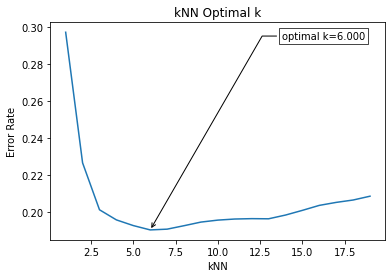

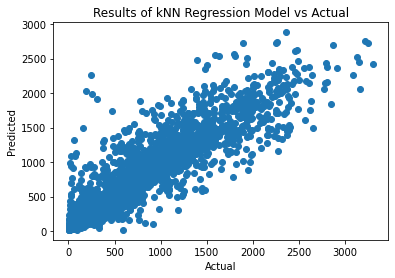

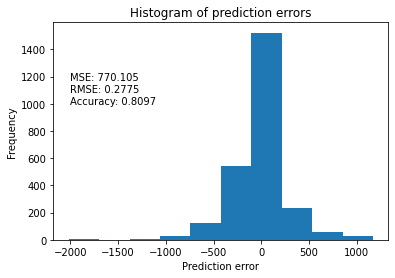

In [ ]:
import matplotlib.pyplot as plt

def annot_min(x,y, ax=None):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "optimal k={:.3f}".format(xmin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.96), **kw)

#show optimal k
fig, ax = plt.subplots()
ax.plot(X_Results, Y_Results)
ax.set_xlabel('kNN')
ax.set_ylabel('Error Rate')
plt.title('kNN Optimal k')
minY = min(Y_Results)
y_index = np.where(Y_Results == minY)
annot_min(X_Results, Y_Results)
plt.show()

#compare results vs actual
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_knn)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Results of kNN Regression Model vs Actual')
plt.show()

plt.hist(y_test - y_pred_knn)
plt.annotate("MSE: " + str(round(mse_knn,4)) + "\nRMSE: " +str(round(rmse_knn,4)) + "\nAccuracy: " + str(round(score_knn,4)), (-2000,1000))
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')
plt.show()